<a href="https://colab.research.google.com/github/sychun/colab/blob/master/h_nn_rnn_6_yfinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install yfinance # http://finance.yahoo.com/

     |████████████████████████████████| 5.5MB 6.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=1416674f88da8284c985893d7f00f24c1613e4e4fcccfc478e466a5e00e4aa64
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
import yfinance as yf

In [9]:
ticker = yf.Ticker('051910.KS')
data = ticker.history(period='max')

In [10]:
print(type(data_lg))
print(data_lg.shape)
data.head()

<class 'pandas.core.frame.DataFrame'>
(4832, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-04-25,9741.689716,9741.689716,8297.232275,8733.928711,3094900,0.0,0
2001-04-26,9741.689716,9741.689716,8297.232275,8733.928711,3094900,0.0,0
2001-04-27,8162.861763,8599.558071,8062.085691,8532.374023,854300,0.0,0
2001-04-30,8364.414413,8633.150620,8364.414413,8599.558594,803200,0.0,0
2001-05-02,8666.744644,8901.888878,8498.784476,8733.928711,851500,0.0,0


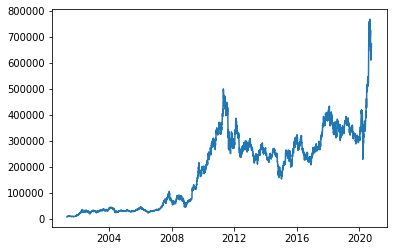

In [11]:
import matplotlib.pyplot as plt
plt.plot(data['Close'])
plt.show()

In [22]:
df = data[data.columns[:5]]
df = df.reset_index(drop=True)
df.head()

,Open,High,Low,Close,Volume
0,9741.689716,9741.689716,8297.232275,8733.928711,3094900
1,9741.689716,9741.689716,8297.232275,8733.928711,3094900
2,8162.861763,8599.558071,8062.085691,8532.374023,854300
3,8364.414413,8633.150620,8364.414413,8599.558594,803200
4,8666.744644,8901.888878,8498.784476,8733.928711,851500


In [23]:
# NN에서는 0 ~ 1 사이의 작은 수치를 원하기 때문에 scaling 필요

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.min(), scaled_data.max()

(0.0, 1.0)

In [24]:
training_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - training_size
train, test = scaled_data[:training_size], scaled_data[training_size:] # 위 라인 필요 없음

In [25]:
print (train.shape, test.shape)

(3382, 5) (1450, 5)


In [26]:
# RNN에 들어가기 위해서는 10000 x 5 ---> 9900? x 100 x 5

import numpy as np

X_train = []
y_train = []

for i in range(100, len(train) - 1): # 내일 자 데이터는 남겨놓아야...
  X_train.append(train[i-100:i, :]) # 100일간의 데이터와
  y_train.append(train[i, 3]) # 그 다음 날 종가 데이터

X_train = np.array(X_train)
y_train = np.array(y_train)  

In [27]:
X_train.shape, y_train.shape # 100일치 데이터를 가지고 다음 날 예측

((3281, 100, 5), (3281,))

In [51]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.LSTM(50, input_shape=(100, 5), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.LSTM(50))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 50)           11200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss='mse', optimizer='rmsprop')
model.fit(X_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
52/52 [==============================] - 36s 695ms/step - loss: 0.0036
Epoch 2/5
52/52 [==============================] - 36s 693ms/step - loss: 0.0012
Epoch 3/5
52/52 [==============================] - 35s 672ms/step - loss: 0.0011
Epoch 4/5
52/52 [==============================] - 36s 687ms/step - loss: 9.9239e-04
Epoch 5/5
52/52 [==============================] - 34s 651ms/step - loss: 8.9570e-04


In [53]:
# 위 train 구문 복사

X_test = []
y_test = []

for i in range(100, len(test) - 1): # 내일 자 데이터는 남겨놓아야...
  X_test.append(test[i-100:i, :]) # 100일간의 데이터와
  y_test.append(test[i, 3]) # 그 다음 날 종가 데이터

X_test = np.array(X_test)
y_test = np.array(y_test) 

In [54]:
X_test.shape, y_test.shape

((1349, 100, 5), (1349,))

In [55]:
predicted_train = model.predict(X_train )
predicted_test = model.predict(X_test)

In [56]:
predicted_train.mean() # because scaled

0.16164324

In [57]:
close_scaler = MinMaxScaler().fit(df['Close'].values.reshape(-1, 1))

# 0 ~ 1 ---> 실제 값으로 복원

predicted_train = close_scaler.inverse_transform(predicted_train)
predicted_test = close_scaler.inverse_transform(predicted_test)

In [58]:
df.head()

,Open,High,Low,Close,Volume
0,9741.689716,9741.689716,8297.232275,8733.928711,3094900
1,9741.689716,9741.689716,8297.232275,8733.928711,3094900
2,8162.861763,8599.558071,8062.085691,8532.374023,854300
3,8364.414413,8633.150620,8364.414413,8599.558594,803200
4,8666.744644,8901.888878,8498.784476,8733.928711,851500


In [59]:
predicted_test.max(), df['Close'].max() # 예측치 보기

(562866.6, 768000.0)

In [60]:
from sklearn.metrics import mean_squared_error

# 원래 값으로 되돌리기 scaled전으로
r_y_train = close_scaler.inverse_transform(y_train.reshape(-1, 1))
r_y_test = close_scaler.inverse_transform(y_test.reshape(-1, 1))

print(np.sqrt( mean_squared_error(r_y_train, predicted_train)))
print(np.sqrt( mean_squared_error(r_y_test, predicted_test)))

13417.243744275707
39865.26875735732


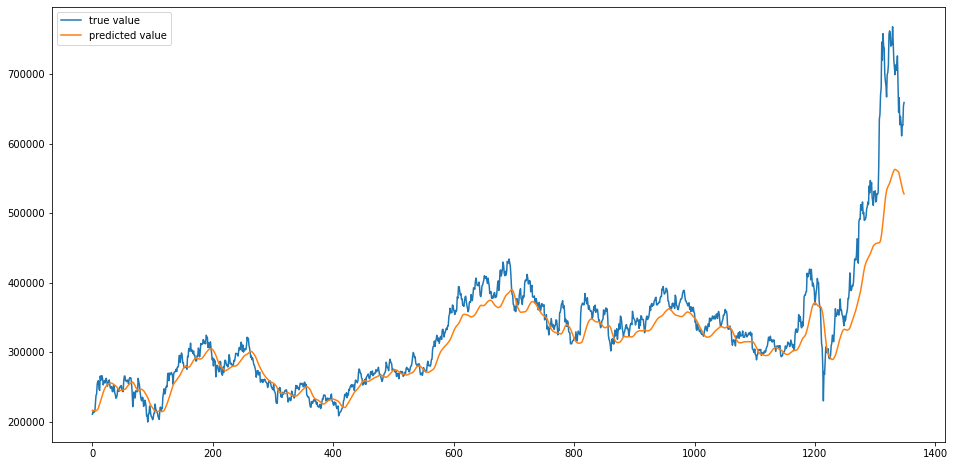

In [61]:
plt.figure(figsize=(16,8))
plt.plot(r_y_test, label='true value')
plt.plot(predicted_test, label='predicted value')
plt.legend()
plt.show()